In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
import pandas as pd

In [3]:
# Load the dataset
url = 'https://raw.githubusercontent.com/Timothy965/COMP262_GROUP5/main/Dataset/Gift_Cards_5.json'
df = pd.read_json(url, lines=True)

# Function to check if a column is hashable
def is_hashable(s):
    return all(isinstance(x, (int, float, str, bool)) for x in s.dropna())

Total number of reviews: 2972
Average rating: 4.885262449528937
Average review length: 67.46729602157788


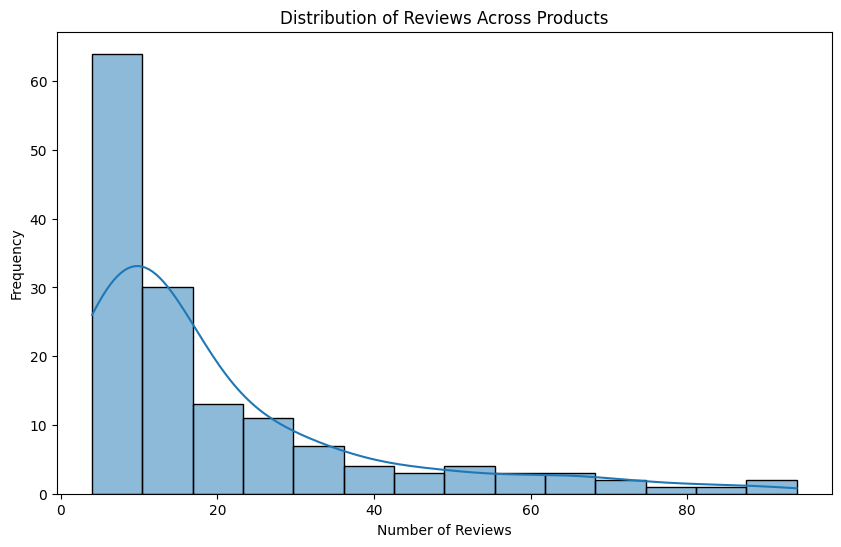

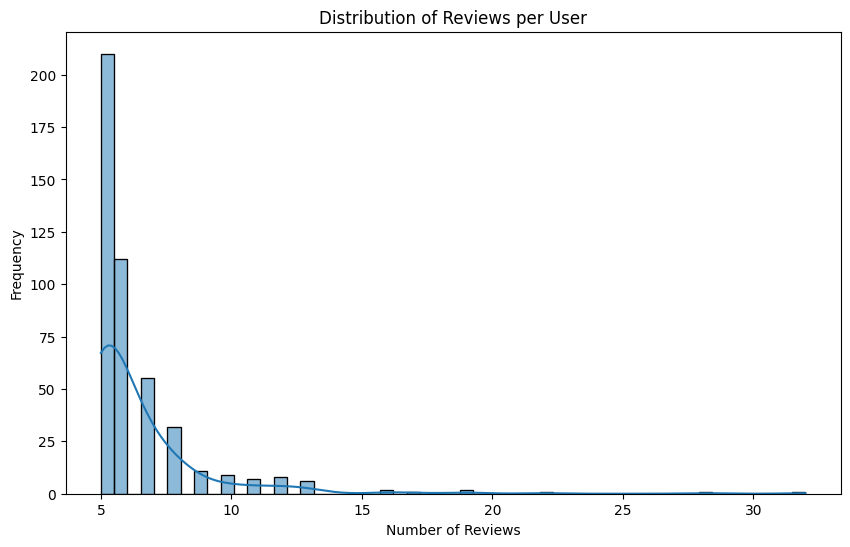

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


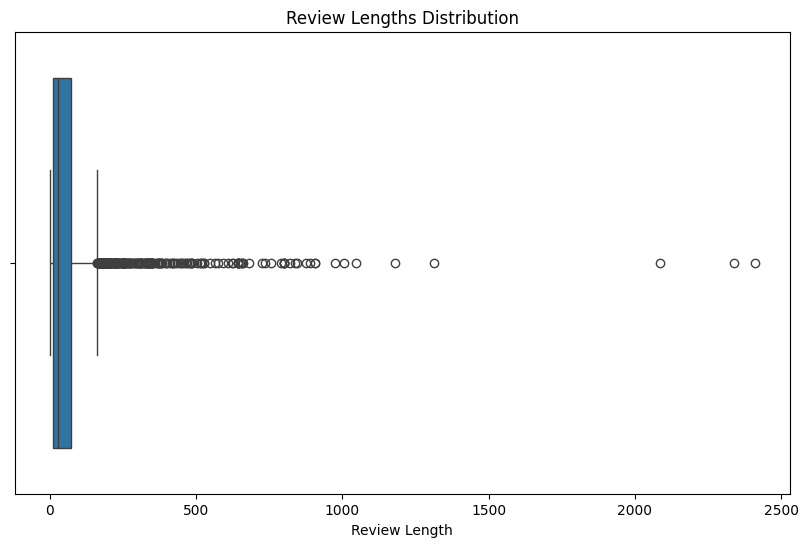

Minimum review length: 2.0
Maximum review length: 2409.0
Median review length: 29.0
Columns used for duplicate checking: ['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote']
Number of duplicate reviews (using hashable columns): 0


In [4]:
# 1. Dataset data exploration
# a) Counts, averages
print("Total number of reviews:", len(df))
print("Average rating:", df['overall'].mean())
print("Average review length:", df['reviewText'].str.len().mean())

# b) Distribution of the number of reviews across products
product_review_counts = df['asin'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(product_review_counts, kde=True)
plt.title('Distribution of Reviews Across Products')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# d) Distribution of reviews per user
user_review_counts = df['reviewerID'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, kde=True)
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# e) Review lengths and outliers
review_lengths = df['reviewText'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(x=review_lengths)
plt.title('Review Lengths Distribution')
plt.xlabel('Review Length')
plt.show()

# f) Analyze lengths
print("Minimum review length:", review_lengths.min())
print("Maximum review length:", review_lengths.max())
print("Median review length:", review_lengths.median())

# g) Check for duplicates
# We'll check for duplicates using only hashable columns
hashable_columns = [col for col in df.columns if is_hashable(df[col])]
print("Columns used for duplicate checking:", hashable_columns)
duplicate_count = df.duplicated(subset=hashable_columns).sum()
print("Number of duplicate reviews (using hashable columns):", duplicate_count)

In [5]:
# 2. Text basic pre-processing

# a) Label data based on rating
def label_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['overall'].apply(label_sentiment)

# b) Choose appropriate columns for sentiment analysis
selected_columns = ['reviewText', 'summary', 'sentiment']
sentiment_df = df[selected_columns]

# c) Check for outliers in review length
Q1 = review_lengths.quantile(0.25)
Q3 = review_lengths.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [6]:
outliers = review_lengths[(review_lengths < lower_bound) | (review_lengths > upper_bound)]
print(f"Number of outliers in review length: {len(outliers)}")

Number of outliers in review length: 271


In [7]:
# Display first few rows of the sentiment dataframe
print(sentiment_df.head())

                                         reviewText  \
0                               Another great gift.   
1                         Gift card for my daughter   
2                                      Nice present   
3  My niece loved this birthday greeting/gift card.   
4                                   fine as a gift.   

                          summary sentiment  
0                      Five Stars  Positive  
1                     Ease of use  Positive  
2                      Five Stars  Positive  
3  Love the convenience of eCards  Positive  
4                      Five Stars  Positive  


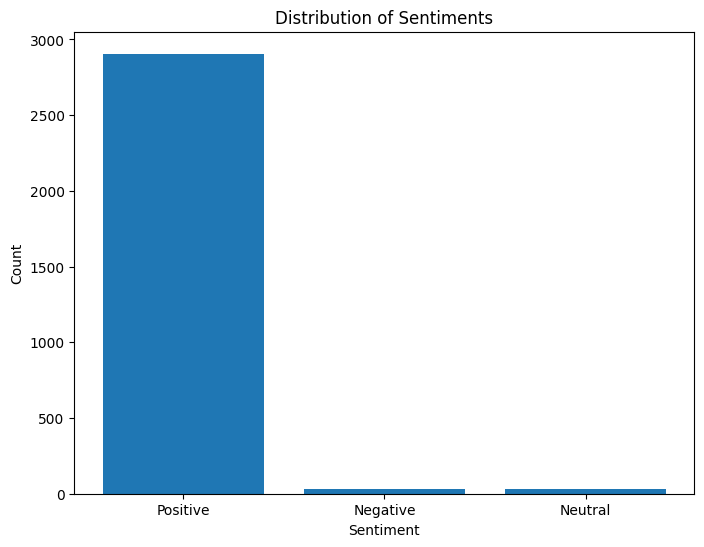

In [8]:
# Distribution of sentiments
sentiment_counts = Counter(sentiment_df['sentiment'])
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values())
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [10]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [11]:
# Pre-process the text
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)


In [13]:
sentiment_df = pd.DataFrame(sentiment_df)
sentiment_df.loc[:, 'reviewText'] = sentiment_df['reviewText'].astype(str).apply(preprocess_text)
sentiment_df.loc[:, 'summary'] = sentiment_df['summary'].astype(str).apply(preprocess_text)